In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [2]:
import numpy as np
import scipy.stats as scistats

from matplotlib import pyplot as plt

In [3]:
from sampling.general_transforms import *
from utils.randomVariable import *
from sampling.accept_reject import *

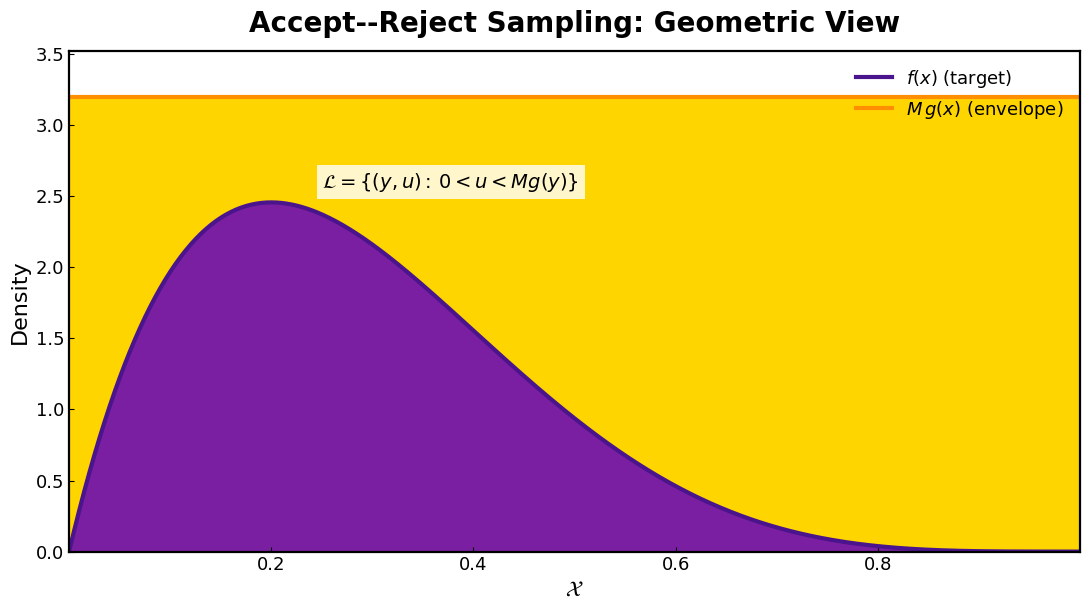

In [6]:
target = scistats.beta(2, 5)
proposal = scistats.uniform(0, 1)
M = 3.2  # envelope constant

save_path_1 = os.path.join(ROOT, "images/sampling/accept_reject_demo.png")
accept_reject_plot(target, proposal, M, save_path=save_path_1)


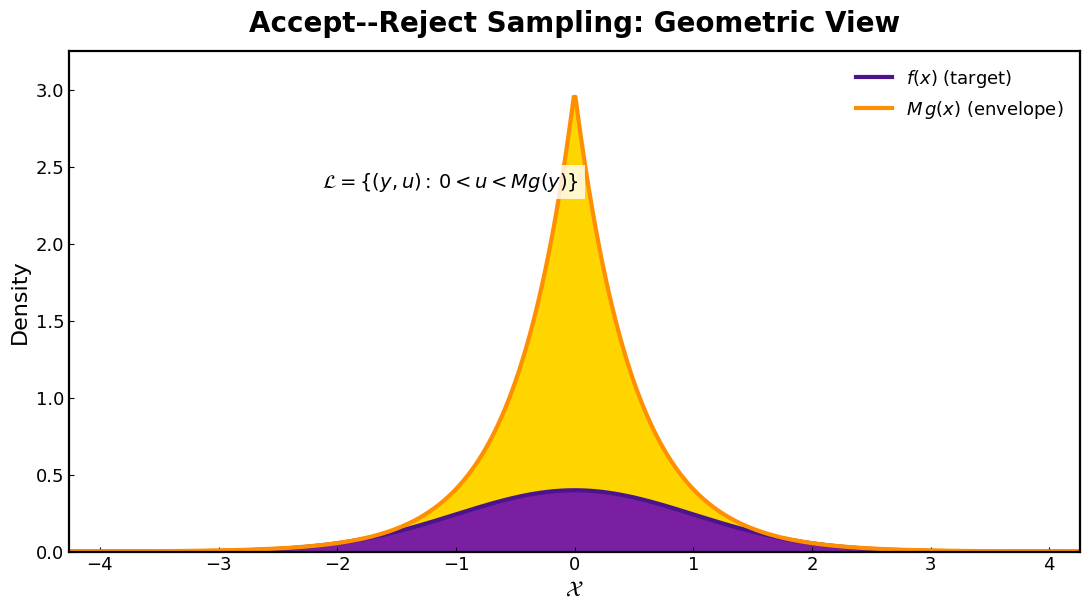

In [7]:
target = scistats.norm(loc=0, scale=1)
proposal_b05 = scistats.laplace(loc=0, scale=0.5)
M2 =  3
save_path_2=os.path.join(ROOT,"images/sampling/accept_reject_demo2.png")
accept_reject_plot(target, proposal_b05, M2, save_path=save_path_2)

## Example: Sampling from $\mathcal{N}(0,1)$ using a Laplace Proposal

### Problem Setup

We want to generate samples from the target density

$$
f(x) = \frac{1}{\sqrt{2\pi}}\, e^{-x^2/2}, \qquad x \in \mathbb{R}
$$

using the **Accept–Reject** method.

As the proposal, we choose the symmetric **Laplace** (double-exponential) distribution:

$$
g(x) = \frac{1}{2b}\, e^{-|x|/b}, \qquad x \in \mathbb{R}
$$

where $b > 0$ is the scale parameter.  
The Laplace density is simple to sample from and has exponential tails that can efficiently cover the Gaussian target.

---

### Finding the Envelope Constant $M$

To apply the Accept–Reject method, we must find the smallest constant $M$ such that

$$
f(x) \le M g(x) \quad \text{for all } x \in \mathbb{R}.
$$

This leads to

$$
\begin{aligned}
M
&= \sup_{x \in \mathbb{R}} \frac{f(x)}{g(x)} \\[4pt]
&= \sup_{x \in \mathbb{R}}
\frac{\tfrac{1}{\sqrt{2\pi}} e^{-x^2/2}}
{\tfrac{1}{2b} e^{-|x|/b}} \\[4pt]
&= \frac{2b}{\sqrt{2\pi}}
\sup_{x \ge 0} \exp\!\left(-\frac{x^2}{2} + \frac{x}{b}\right)
\end{aligned}
$$

where we use symmetry to restrict to $x \ge 0$.

---

### Maximizing the Exponent

To find the maximum of the exponential term, differentiate the exponent with respect to $x$:

$$
\frac{d}{dx}\!\left(-\frac{x^2}{2} + \frac{x}{b}\right) = -x + \frac{1}{b}.
$$

Setting this derivative equal to zero gives

$$
x^\ast = \frac{1}{b}.
$$

Evaluating the exponent at this point,

$$
-\frac{(x^\ast)^2}{2} + \frac{x^\ast}{b}
= -\frac{1}{2b^2} + \frac{1}{b^2}
= \frac{1}{2b^2}.
$$

Substituting back, we obtain

$$
M = \frac{2b}{\sqrt{2\pi}}\, \exp\!\left(\frac{1}{2b^2}\right)
$$

---

### Optimizing over $b$

If the scale parameter $b$ is adjustable, we can minimize $M(b)$ with respect to $b$ to find the most efficient proposal.  
Differentiating and setting $\tfrac{dM}{db}=0$ gives

$$
\begin{aligned}
M(b) &= \frac{2b}{\sqrt{2\pi}}\, e^{1/(2b^2)}, \\[4pt]
\frac{dM}{db} &= \frac{2}{\sqrt{2\pi}}\, e^{1/(2b^2)} \left(1 - \frac{1}{b^2}\right) = 0.
\end{aligned}
$$

Hence, the minimum occurs at

$$
b^\ast = 1.
$$

Substituting this value yields

$$
M^\ast = \frac{2}{\sqrt{2\pi}}\, e^{1/2} \approx 1.3154.
$$

---

### Interpretation

The optimal proposal is therefore the $\mathrm{Laplace}(0,1)$ distribution, with an envelope constant of approximately $M = 1.316$.  
This means the Laplace proposal slightly overestimates the Gaussian density, accepting about

$$
\frac{1}{M} \approx 0.76
$$

of proposed samples on average.  

The close match between the Gaussian and Laplace shapes shows that the Laplace envelope provides an efficient, near-optimal cover for $\mathcal{N}(0,1)$.

---

### Summary of Parameters

$$
\begin{aligned}
\text{Target:} &\quad f(x) = \frac{1}{\sqrt{2\pi}}\, e^{-x^2/2}, \\[4pt]
\text{Proposal:} &\quad g(x) = \frac{1}{2}\, e^{-|x|}, \\[4pt]
\text{Envelope Constant:} &\quad M = \frac{2}{\sqrt{2\pi}}\, e^{1/2} \approx 1.316.
\end{aligned}
$$

---

### Next Step: Simulation

We now implement the **Accept–Reject** algorithm using this configuration:

$$
f(x) = \mathcal{N}(0,1), 
\qquad g(x) = \mathrm{Laplace}(0,1),
\qquad M = 1.316
$$

and verify empirically that the accepted samples follow the $\mathcal{N}(0,1)$ distribution.


In [8]:
target = scistats.norm(loc=0, scale=1)
proposal = scistats.laplace(loc=0, scale=1)
M = 1.316  # Envelope constant (≈ optimal from earlier derivation)

In [11]:
result, diag, evlog = accept_reject_sampling(
    num_samples=800,
    proposal_sample_generator=sample_laplace_standard,  
    proposal_pdf_evaluator=proposal.pdf,     
    target_pdf_evaluator=target.pdf,       
    M=M,
    return_diagnostics=True,
    return_event_log=True
)

print("Diagnostics:")
for k, v in diag.items():
    print(f"  {k:20s} : {v:.5f}")

Diagnostics:
  num_samples_requested : 800.00000
  total_proposals      : 1053.00000
  acceptance_rate      : 0.75973
  expected_acceptance  : 0.75988
  rounds               : 1.00000


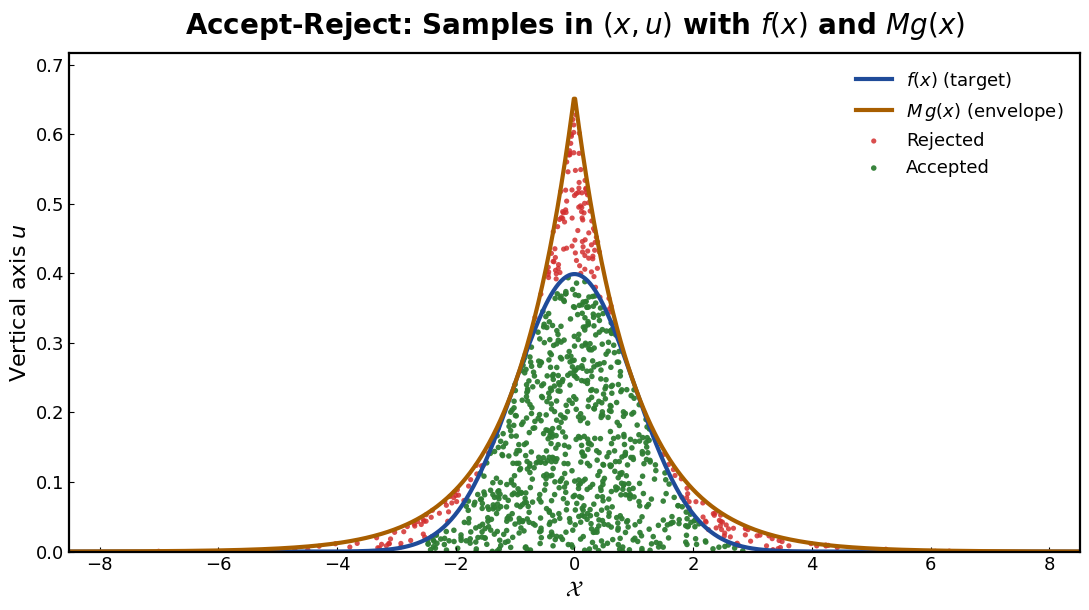

In [13]:
# after running your sampler to get `result` (AcceptRejectSamples)

save_path_3 = os.path.join(ROOT, "images/sampling/accept-reject_standardNormla_laplace.png")
accept_reject_scatter_plot(
    samples=result,
    target_rv=scistats.norm(0,1),
    proposal_rv=scistats.laplace(0,1),
    N=800,
    ppm_thresh=1e-4,
    save_path=save_path_3
)

In [ ]:
save_path_4 = os.path.join(ROOT, "animations/accept_reject_demo.gif")
animate_accept_reject_scatter(
    evlog,
    target_rv=scistats.norm(),
    proposal_rv=scistats.laplace(),
    M=diag["expected_acceptance"]**-1,
    out_path=save_path_4,
    fps=25,
)

'animations/accept_reject_demo.gif'

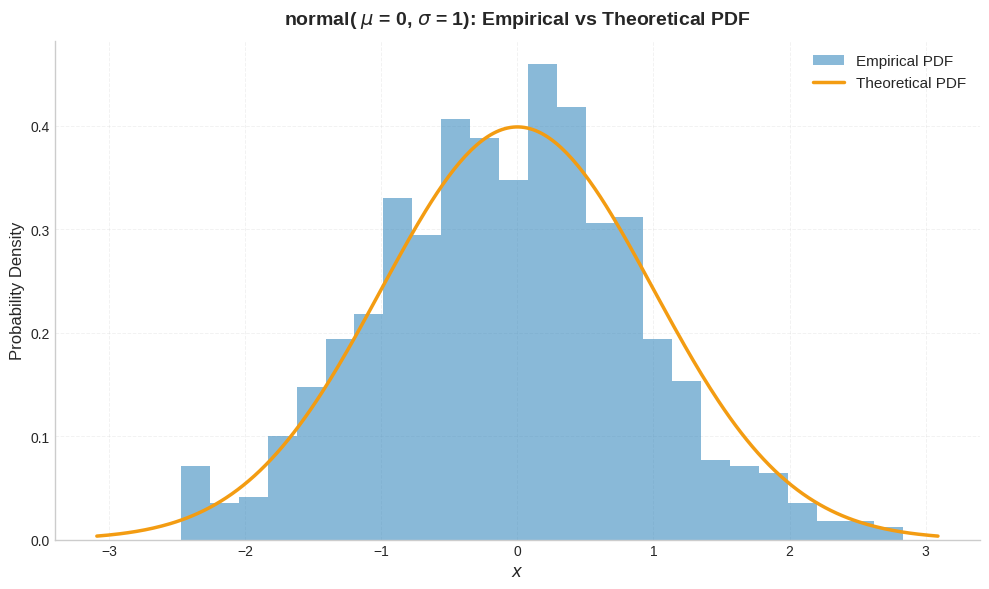

In [15]:
norm_rv = scistats.norm(loc=0, scale=1)
plot_empirical_and_theoretical_pdf(result.x_accepted,norm_rv,dist_name=rf"normal( $\mu$ = {0}, $\sigma$ = {1})")